# Stock prediction

In [21]:
# Imports
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

In [26]:
# Import yfinance
import yfinance as yf  

# bring data to current
import datetime
today = datetime.date.today()
start = '1995-01-03' #beginning of SPY data

# Get the data for the stock SPY by specifying 
# the stock ticker, start date, and end date
data_spy = yf.download('SPY',start, today)

# fill blank data with nan
data_spy.fillna(method='ffill', inplace=True)
    
# renaming columns to make merging of data frames easier (later)
data_spy.columns = ['SPY_OPEN', 'SPY_HIGH', 'SPY_LOW', 'SPY_CLOSE', 'SPY_ADJ_CLOSE', 'SPY_VOLUME']

#sanity check data
data_spy.tail(10)

[*********************100%***********************]  1 of 1 downloaded


,SPY_OPEN,SPY_HIGH,SPY_LOW,SPY_CLOSE,SPY_ADJ_CLOSE,SPY_VOLUME
Date,,,,,,
2019-07-29,301.88,302.01,300.85,301.46,301.46,38126500
2019-07-30,299.91,301.17,299.49,300.72,300.72,45849000
2019-07-31,300.99,301.20,295.20,297.43,297.43,104245200
2019-08-01,297.60,300.87,293.96,294.84,294.84,142646600
2019-08-02,293.85,294.12,290.90,292.62,292.62,116749700
2019-08-05,288.09,288.21,281.72,283.82,283.82,178745400
2019-08-06,285.91,288.04,284.28,287.80,287.80,120711700
2019-08-07,284.40,288.82,282.04,287.97,287.97,140572300
2019-08-08,289.62,293.62,289.01,293.62,293.62,87713900


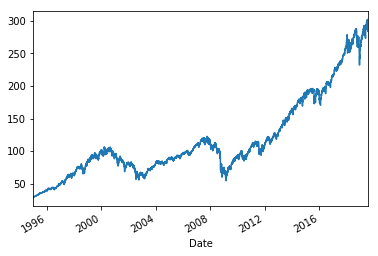

In [27]:
data_spy.SPY_ADJ_CLOSE.plot()
plt.show()

In [19]:
# cache data for later use
# identify missing data with nan for elimination later
data_spy.to_csv('data/spy.csv')

In [43]:
# read data back in - mainly for reproducibility,
# and/or not wanting to download new data...
def get_spy_data():
    def parse(x):
        return pd.to_datetime(x, infer_datetime_format=True)

    data_spy = read_csv('data/spy.csv', date_parser=parse, index_col=0)

    # sanity
    data_spy.tail(10)
    
    return data_spy

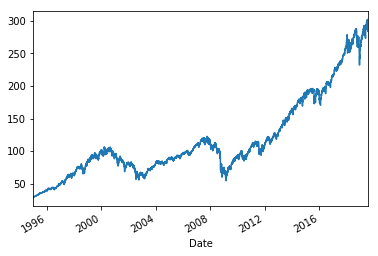

In [44]:
# sanity 
data_spy = get_spy_data()
data_spy.SPY_ADJ_CLOSE.plot()
plt.show()

# First prediction using Kaggle 
### Example as it applies to SPY ETF

In [ ]:
# https://www.kaggle.com/amarpreetsingh/stock-prediction-lstm-using-keras

# with some fixes...

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Archive.zip
all_stocks_5yr.csv
all_stocks_5yr.csv.zip
cleaned.csv
int-combined.csv
int-rate-1995.csv
int-rate-1996.csv
int-rate-1997.csv
int-rate-1998.csv
int-rate-1999.csv
int-rate-2000.csv
int-rate-2001.csv
int-rate-2002.csv
int-rate-2003.csv
int-rate-2004.csv
int-rate-2005.csv
int-rate-2006.csv
int-rate-2007.csv
int-rate-2008.csv
int-rate-2009.csv
int-rate-2010.csv
int-rate-2011.csv
int-rate-2012.csv
int-rate-2013.csv
int-rate-2014.csv
int-rate-2015.csv
int-rate-2016.csv
int-rate-2017.csv
merged.csv
merged_irate.csv
pollution.csv
raw.csv
spy.csv
vix.csv
vixarchive.csv
vixarchive.xlsx
vixcurrent.csv



In [6]:
data = pd.read_csv('./data/spy.csv')
cl = data.SPY_ADJ_CLOSE

In [7]:
cl[:10]
cl.shape

(6195,)

In [8]:
scl = MinMaxScaler()
#Scale the data
cl = cl.values.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)
cl

array([[0.00000000e+00],
       [5.13347023e-04],
       [5.13347023e-04],
       ...,
       [9.48518627e-01],
       [9.69235846e-01],
       [9.61902317e-01]])

In [24]:
# hyper params
lb = 20  # 20 and 7 have approx same loss results
train_perc = 0.80

In [25]:
#Create a function to process the data into 7 day look back slices
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)


X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*train_perc)],X[int(X.shape[0]*train_perc):]
y_train,y_test = y[:int(y.shape[0]*train_perc)],y[int(y.shape[0]*train_perc):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

X_train[:5]
#y_train[:5]

4939
1235
4939
1235


array([[0.        , 0.00051335, 0.00051335, 0.00062335, 0.00073335,
        0.00084336, 0.00091669, 0.00095336, 0.00223673, 0.00289674,
        0.00293341, 0.00282341, 0.00220006, 0.00179671, 0.00212672,
        0.00227339, 0.00256674, 0.00267674, 0.00311675, 0.00264007],
       [0.00051335, 0.00051335, 0.00062335, 0.00073335, 0.00084336,
        0.00091669, 0.00095336, 0.00223673, 0.00289674, 0.00293341,
        0.00282341, 0.00220006, 0.00179671, 0.00212672, 0.00227339,
        0.00256674, 0.00267674, 0.00311675, 0.00264007, 0.00308008],
       [0.00051335, 0.00062335, 0.00073335, 0.00084336, 0.00091669,
        0.00095336, 0.00223673, 0.00289674, 0.00293341, 0.00282341,
        0.00220006, 0.00179671, 0.00212672, 0.00227339, 0.00256674,
        0.00267674, 0.00311675, 0.00264007, 0.00308008, 0.00304341],
       [0.00062335, 0.00073335, 0.00084336, 0.00091669, 0.00095336,
        0.00223673, 0.00289674, 0.00293341, 0.00282341, 0.00220006,
        0.00179671, 0.00212672, 0.00227339, 0

In [26]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

Train on 4939 samples, validate on 1235 samples
Epoch 1/300
4939/4939 [==============================] - 25s 5ms/step - loss: 4.7427e-04 - val_loss: 0.0033
Epoch 2/300
4939/4939 [==============================] - 21s 4ms/step - loss: 0.0012 - val_loss: 0.0069
Epoch 3/300
4939/4939 [==============================] - 21s 4ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 4/300
4939/4939 [==============================] - 21s 4ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 5/300
4939/4939 [==============================] - 21s 4ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 6/300
4939/4939 [==============================] - 21s 4ms/step - loss: 7.9288e-04 - val_loss: 0.0011
Epoch 7/300
4939/4939 [==============================] - 21s 4ms/step - loss: 3.9461e-04 - val_loss: 8.7671e-04
Epoch 8/300
4939/4939 [==============================] - 21s 4ms/step - loss: 1.2671e-04 - val_loss: 2.9641e-04
Epoch 9/300
4939/4939 [==============================] - 21s 4ms/step - loss: 3.6348e-05 - val_l

4939/4939 [==============================] - 14s 3ms/step - loss: 2.0196e-05 - val_loss: 0.0014
Epoch 146/300
4939/4939 [==============================] - 14s 3ms/step - loss: 1.9841e-05 - val_loss: 0.0015
Epoch 147/300
4939/4939 [==============================] - 14s 3ms/step - loss: 2.0255e-05 - val_loss: 0.0015
Epoch 148/300
4939/4939 [==============================] - 12s 2ms/step - loss: 1.9732e-05 - val_loss: 0.0015
Epoch 149/300
4939/4939 [==============================] - 12s 2ms/step - loss: 2.0133e-05 - val_loss: 0.0016
Epoch 150/300
4939/4939 [==============================] - 12s 2ms/step - loss: 2.0054e-05 - val_loss: 0.0015
Epoch 151/300
4939/4939 [==============================] - 15s 3ms/step - loss: 2.0317e-05 - val_loss: 0.0016
Epoch 152/300
4939/4939 [==============================] - 14s 3ms/step - loss: 2.0400e-05 - val_loss: 0.0016
Epoch 153/300
4939/4939 [==============================] - 15s 3ms/step - loss: 2.0533e-05 - val_loss: 0.0016
Epoch 154/300
4939/4939 

4939/4939 [==============================] - 11s 2ms/step - loss: 2.2464e-05 - val_loss: 6.2479e-04
Epoch 292/300
4939/4939 [==============================] - 11s 2ms/step - loss: 2.1750e-05 - val_loss: 6.1969e-04
Epoch 293/300
4939/4939 [==============================] - 11s 2ms/step - loss: 2.2843e-05 - val_loss: 6.1126e-04
Epoch 294/300
4939/4939 [==============================] - 11s 2ms/step - loss: 1.7857e-05 - val_loss: 6.4646e-04
Epoch 295/300
4939/4939 [==============================] - 11s 2ms/step - loss: 2.1035e-05 - val_loss: 5.6030e-04
Epoch 296/300
4939/4939 [==============================] - 11s 2ms/step - loss: 2.1299e-05 - val_loss: 5.1905e-04
Epoch 297/300
4939/4939 [==============================] - 11s 2ms/step - loss: 2.0579e-05 - val_loss: 5.1181e-04
Epoch 298/300
4939/4939 [==============================] - 11s 2ms/step - loss: 2.0783e-05 - val_loss: 4.8208e-04
Epoch 299/300
4939/4939 [==============================] - 11s 2ms/step - loss: 1.9600e-05 - val_loss:

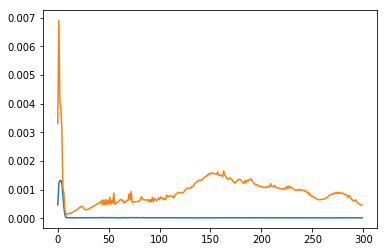

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [28]:
X_test[0]

array([[0.54264447],
       [0.5424978 ],
       [0.54796128],
       [0.55137137],
       [0.55313142],
       [0.5550748 ],
       [0.55404811],
       [0.55738486],
       [0.55782488],
       [0.5575682 ],
       [0.55720153],
       [0.55907158],
       [0.55874157],
       [0.55837489],
       [0.55742153],
       [0.56042828],
       [0.55866823],
       [0.55445145],
       [0.55694485],
       [0.55771487]])

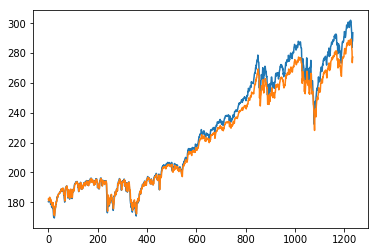

In [30]:
Xt = model.predict(X_test.reshape(-1,lb,1))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [31]:
act = []
pred = []
for i in range(250):
#i=249
    Xt = model.predict(X_test[i].reshape(1,lb,1))
    print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
    pred.append(scl.inverse_transform(Xt))
    act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))

predicted:[[182.03616]], actual:[[180.33]]
predicted:[[181.07678]], actual:[[180.2]]
predicted:[[180.9324]], actual:[[181.55]]
predicted:[[182.16719]], actual:[[181.8]]
predicted:[[182.44]], actual:[[182.77]]
predicted:[[183.33128]], actual:[[182.6]]
predicted:[[183.20792]], actual:[[181.19]]
predicted:[[181.89745]], actual:[[180.16]]
predicted:[[180.89543]], actual:[[181.57]]
predicted:[[182.14082]], actual:[[178.64]]
predicted:[[179.52332]], actual:[[180.06]]
predicted:[[180.73492]], actual:[[179.73]]
predicted:[[180.51909]], actual:[[179.26]]
predicted:[[180.07962]], actual:[[176.83]]
predicted:[[177.8612]], actual:[[176.85]]
predicted:[[177.79568]], actual:[[178.8]]
predicted:[[179.58105]], actual:[[178.59]]
predicted:[[179.45753]], actual:[[175.83]]
predicted:[[176.9407]], actual:[[178.91]]
predicted:[[179.66971]], actual:[[175.36]]
predicted:[[176.52168]], actual:[[173.36]]
predicted:[[174.55289]], actual:[[170.51]]
predicted:[[171.90202]], actual:[[170.78]]
predicted:[[172.05652

predicted:[[191.48457]], actual:[[191.43]]
predicted:[[191.39565]], actual:[[190.89]]
predicted:[[190.92194]], actual:[[192.09]]
predicted:[[192.00368]], actual:[[188.86]]
predicted:[[189.09665]], actual:[[189.21]]
predicted:[[189.26865]], actual:[[191.59]]
predicted:[[191.45697]], actual:[[193.7]]
predicted:[[193.45375]], actual:[[194.54]]
predicted:[[194.29433]], actual:[[194.48]]
predicted:[[194.26013]], actual:[[196.04]]
predicted:[[195.64012]], actual:[[196.21]]
predicted:[[195.8088]], actual:[[196.31]]
predicted:[[195.86127]], actual:[[195.53]]
predicted:[[195.14505]], actual:[[195.18]]
predicted:[[194.79332]], actual:[[194.08]]
predicted:[[193.79431]], actual:[[192.07]]
predicted:[[191.94661]], actual:[[190.95]]
predicted:[[190.8857]], actual:[[193.3]]
predicted:[[193.01486]], actual:[[194.63]]
predicted:[[194.3394]], actual:[[194.67]]
predicted:[[194.42862]], actual:[[194.38]]
predicted:[[194.1645]], actual:[[193.72]]
predicted:[[193.52875]], actual:[[193.34]]
predicted:[[193.1

In [32]:
result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})

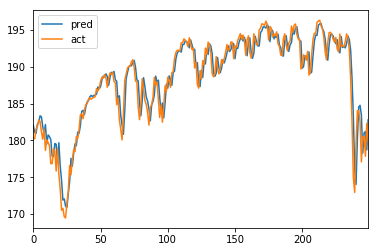

In [33]:
result_df.plot(kind='line')

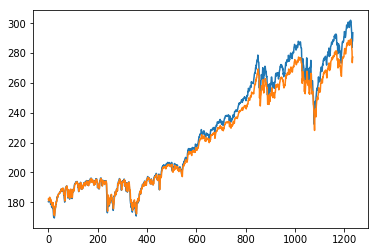

In [34]:
Xt = model.predict(X_test.reshape(-1,lb,1))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [35]:
X_test[249]

array([[0.59914931],
       [0.59999267],
       [0.59911264],
       [0.60167938],
       [0.60563948],
       [0.6035861 ],
       [0.59793928],
       [0.58323555],
       [0.562445  ],
       [0.53424758],
       [0.52669405],
       [0.55104136],
       [0.5673218 ],
       [0.56735846],
       [0.56189498],
       [0.54191112],
       [0.55423145],
       [0.55470813],
       [0.54469786],
       [0.5610883 ]])

In [36]:
X_test[248]

array([[0.60556615],
       [0.59914931],
       [0.59999267],
       [0.59911264],
       [0.60167938],
       [0.60563948],
       [0.6035861 ],
       [0.59793928],
       [0.58323555],
       [0.562445  ],
       [0.53424758],
       [0.52669405],
       [0.55104136],
       [0.5673218 ],
       [0.56735846],
       [0.56189498],
       [0.54191112],
       [0.55423145],
       [0.55470813],
       [0.54469786]])

# Continuing above methodology with monthly SPY data 

### Reworking SPY prediction based on monthly time series data

In [29]:
# Import yfinance
import yfinance as yf  

spy_monthly = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "SPY",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1mo",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

# fill blank data with nan
spy_monthly.fillna(method='ffill', inplace=True)
# only want data from 1st of the month, no mid-month data required
spy_monthly = spy_monthly.loc[ spy_monthly.index.day == 1 , : ]
# renaming columns to make merging of data frames easier (later)
spy_monthly.columns = ['SPY_OPEN', 'SPY_HIGH', 'SPY_LOW', 'SPY_CLOSE', 'SPY_VOLUME']
#sanity check data
spy_monthly.tail(10)

[*********************100%***********************]  1 of 1 downloaded


,SPY_OPEN,SPY_HIGH,SPY_LOW,SPY_CLOSE,SPY_VOLUME
Date,,,,,
2018-11-01,267.54,277.01,259.14,271.53,2.021061e+09
2018-12-01,276.09,276.21,230.26,246.18,3.102780e+09
2019-01-01,243.72,267.98,241.43,267.45,2.048692e+09
2019-02-01,267.66,278.72,265.36,276.11,1.371716e+09
2019-03-01,277.86,282.56,269.91,279.88,1.678081e+09
2019-04-01,283.32,293.02,283.02,292.60,1.209205e+09
2019-05-01,293.29,293.52,273.91,273.94,1.845593e+09
2019-06-01,273.98,294.88,271.77,291.58,1.340436e+09
2019-07-01,296.68,302.23,294.33,297.43,1.110504e+09


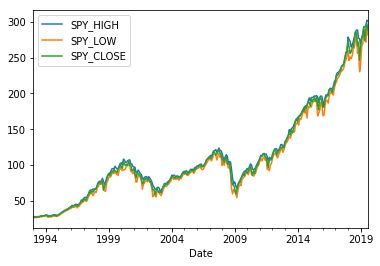

In [43]:
import matplotlib.pyplot as plt
graph_data = spy_monthly.iloc[:,1:4]
graph_data.plot(subplots=False, legend=True)
plt.show()

In [51]:
cl = spy_monthly.SPY_CLOSE
cl.tail()

Date
2019-04-01    292.60
2019-05-01    273.94
2019-06-01    291.58
2019-07-01    297.43
2019-08-01    288.07
Name: SPY_CLOSE, dtype: float64

In [52]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
#Scale the data
cl = cl.values.reshape(cl.shape[0],1)
cl = scl.fit_transform(cl)
cl

array([[0.00000000e+00],
       [1.03427896e-03],
       [2.80732861e-03],
       [6.64893617e-04],
       [3.36140662e-03],
       [2.99202128e-03],
       [3.21365248e-03],
       [7.12913712e-03],
       [5.68853428e-03],
       [8.42198582e-03],
       [7.27689125e-03],
       [7.86790780e-03],
       [1.23374704e-02],
       [9.08687943e-03],
       [3.98936170e-03],
       [5.72547281e-03],
       [7.38770686e-03],
       [4.28486998e-03],
       [8.31117021e-03],
       [1.23744090e-02],
       [8.93912530e-03],
       [1.26699173e-02],
       [8.23729314e-03],
       [8.16341608e-03],
       [1.26329787e-02],
       [1.71764184e-02],
       [1.97621158e-02],
       [2.39361702e-02],
       [2.87751182e-02],
       [3.05851064e-02],
       [3.55348700e-02],
       [3.61258865e-02],
       [4.11125887e-02],
       [4.14450355e-02],
       [4.76876478e-02],
       [4.90543735e-02],
       [5.52600473e-02],
       [5.57402482e-02],
       [5.76979905e-02],
       [6.01359338e-02],


In [61]:
# hyper params
lb = 5  # 20 and 7 have approx same loss results
train_perc = 0.80

In [62]:
import numpy as np
#Create a function to process the data into 7 day look back slices
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)


X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*train_perc)],X[int(X.shape[0]*train_perc):]
y_train,y_test = y[:int(y.shape[0]*train_perc)],y[int(y.shape[0]*train_perc):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

X_train[:5]
#y_train[:5]

251
63
251
63


array([[0.        , 0.00103428, 0.00280733, 0.00066489, 0.00336141],
       [0.00103428, 0.00280733, 0.00066489, 0.00336141, 0.00299202],
       [0.00280733, 0.00066489, 0.00336141, 0.00299202, 0.00321365],
       [0.00066489, 0.00336141, 0.00299202, 0.00321365, 0.00712914],
       [0.00336141, 0.00299202, 0.00321365, 0.00712914, 0.00568853]])

In [63]:
from keras.models import Sequential
from keras.layers import LSTM,Dense

#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)

Train on 251 samples, validate on 63 samples
Epoch 1/300
251/251 [==============================] - 2s 10ms/step - loss: 0.0153 - val_loss: 0.0452
Epoch 2/300
251/251 [==============================] - 0s 977us/step - loss: 0.0075 - val_loss: 0.0245
Epoch 3/300
251/251 [==============================] - 0s 901us/step - loss: 0.0040 - val_loss: 0.0402
Epoch 4/300
251/251 [==============================] - 0s 796us/step - loss: 7.4449e-04 - val_loss: 0.0033
Epoch 5/300
251/251 [==============================] - 0s 924us/step - loss: 0.0015 - val_loss: 0.0033
Epoch 6/300
251/251 [==============================] - 0s 832us/step - loss: 7.6451e-04 - val_loss: 0.0017
Epoch 7/300
251/251 [==============================] - 0s 805us/step - loss: 6.9806e-04 - val_loss: 0.0017
Epoch 8/300
251/251 [==============================] - 0s 1ms/step - loss: 5.9318e-04 - val_loss: 0.0013
Epoch 9/300
251/251 [==============================] - 0s 812us/step - loss: 6.1849e-04 - val_loss: 0.0015
Epoch 10/30

Epoch 77/300
251/251 [==============================] - 0s 880us/step - loss: 4.4858e-04 - val_loss: 0.0052
Epoch 78/300
251/251 [==============================] - 0s 892us/step - loss: 4.4642e-04 - val_loss: 0.0053
Epoch 79/300
251/251 [==============================] - 0s 810us/step - loss: 4.4432e-04 - val_loss: 0.0054
Epoch 80/300
251/251 [==============================] - 0s 777us/step - loss: 4.4220e-04 - val_loss: 0.0055
Epoch 81/300
251/251 [==============================] - 0s 2ms/step - loss: 4.4004e-04 - val_loss: 0.0056
Epoch 82/300
251/251 [==============================] - 0s 836us/step - loss: 4.3793e-04 - val_loss: 0.0057
Epoch 83/300
251/251 [==============================] - 0s 784us/step - loss: 4.3594e-04 - val_loss: 0.0058
Epoch 84/300
251/251 [==============================] - 0s 852us/step - loss: 4.3386e-04 - val_loss: 0.0059
Epoch 85/300
251/251 [==============================] - 0s 944us/step - loss: 4.3174e-04 - val_loss: 0.0059
Epoch 86/300
251/251 [========

251/251 [==============================] - 0s 861us/step - loss: 3.3269e-04 - val_loss: 0.0083
Epoch 153/300
251/251 [==============================] - 0s 860us/step - loss: 3.3122e-04 - val_loss: 0.0082
Epoch 154/300
251/251 [==============================] - 0s 873us/step - loss: 3.2932e-04 - val_loss: 0.0082
Epoch 155/300
251/251 [==============================] - 0s 813us/step - loss: 3.2803e-04 - val_loss: 0.0082
Epoch 156/300
251/251 [==============================] - 0s 1ms/step - loss: 3.2769e-04 - val_loss: 0.0082
Epoch 157/300
251/251 [==============================] - 0s 942us/step - loss: 3.2749e-04 - val_loss: 0.0081
Epoch 158/300
251/251 [==============================] - 0s 817us/step - loss: 3.2656e-04 - val_loss: 0.0080
Epoch 159/300
251/251 [==============================] - 0s 826us/step - loss: 3.2482e-04 - val_loss: 0.0080
Epoch 160/300
251/251 [==============================] - 0s 813us/step - loss: 3.2325e-04 - val_loss: 0.0079
Epoch 161/300
251/251 [============

251/251 [==============================] - 0s 822us/step - loss: 2.7607e-04 - val_loss: 0.0048
Epoch 228/300
251/251 [==============================] - 0s 791us/step - loss: 2.7540e-04 - val_loss: 0.0048
Epoch 229/300
251/251 [==============================] - 0s 799us/step - loss: 2.7476e-04 - val_loss: 0.0048
Epoch 230/300
251/251 [==============================] - 0s 828us/step - loss: 2.7428e-04 - val_loss: 0.0047
Epoch 231/300
251/251 [==============================] - 0s 836us/step - loss: 2.7385e-04 - val_loss: 0.0047
Epoch 232/300
251/251 [==============================] - 0s 2ms/step - loss: 2.7333e-04 - val_loss: 0.0046
Epoch 233/300
251/251 [==============================] - 0s 935us/step - loss: 2.7266e-04 - val_loss: 0.0046
Epoch 234/300
251/251 [==============================] - 0s 934us/step - loss: 2.7202e-04 - val_loss: 0.0046
Epoch 235/300
251/251 [==============================] - 0s 892us/step - loss: 2.7155e-04 - val_loss: 0.0046
Epoch 236/300
251/251 [============

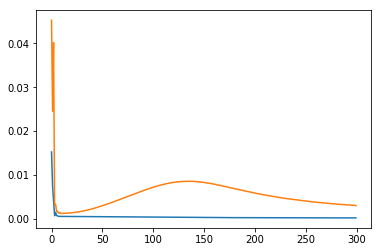

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [65]:
X_test[0]

array([[0.51019504],
       [0.49191046],
       [0.51880171],
       [0.52120272],
       [0.52825798]])

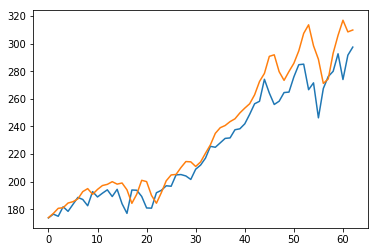

In [66]:
Xt = model.predict(X_test.reshape(-1,lb,1))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [70]:
act = []
pred = []
for i in range(63):
#i=249
    Xt = model.predict(X_test[i].reshape(1,lb,1))
    print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
    pred.append(scl.inverse_transform(Xt))
    act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))

predicted:[[173.84106]], actual:[[173.66]]
predicted:[[176.8893]], actual:[[176.4]]
predicted:[[180.61021]], actual:[[174.86]]
predicted:[[181.0428]], actual:[[181.76]]
predicted:[[184.44458]], actual:[[178.42]]
predicted:[[185.42108]], actual:[[183.48]]
predicted:[[187.44572]], actual:[[188.52]]
predicted:[[192.71683]], actual:[[187.01]]
predicted:[[194.89146]], actual:[[182.47]]
predicted:[[190.75502]], actual:[[192.72]]
predicted:[[194.30643]], actual:[[188.85]]
predicted:[[197.11725]], actual:[[191.56]]
predicted:[[197.98349]], actual:[[194.02]]
predicted:[[199.912]], actual:[[189.16]]
predicted:[[198.14938]], actual:[[194.38]]
predicted:[[198.96317]], actual:[[183.91]]
predicted:[[194.03502]], actual:[[176.95]]
predicted:[[184.22034]], actual:[[193.89]]
predicted:[[190.89546]], actual:[[193.71]]
predicted:[[200.91644]], actual:[[189.23]]
predicted:[[199.97195]], actual:[[180.88]]
predicted:[[189.95056]], actual:[[180.73]]
predicted:[[184.293]], actual:[[191.9]]
predicted:[[191.931

In [72]:
import pandas as pd
result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})

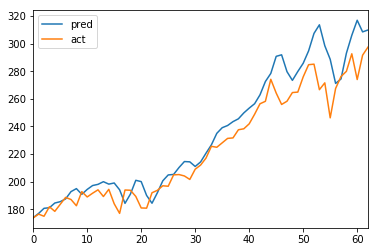

In [73]:
result_df.plot(kind='line')

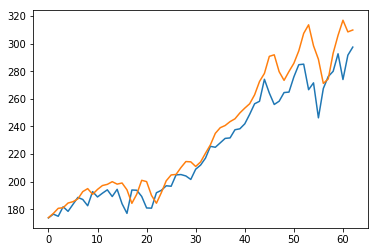

In [74]:
Xt = model.predict(X_test.reshape(-1,lb,1))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

# Another Prediction Keras with shifting...multivariate... in progress...

In [42]:
# First Attempt at prediciton will use code based on
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [45]:
# hyper params
look_back = 20
epochs = 20
batch_size = 128

In [29]:
# get values for LSTM processing
values = data_spy.values
values = values.astype('float32')

In [31]:
# normalize features
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [35]:
#https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [37]:
# frame as supervised learning
supervised = series_to_supervised(scaled, 1, 1)
# drop columns that are not predicted
#supervised.drop(supervised.columns[[10,11,12,13,15,16,17,18,19]], axis=1, inplace=True)
print(supervised.tail())

# split into train and test sets
values = supervised.values

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
6190   0.968655   0.968368   0.961005   0.963353   0.965569   0.134027   
6191   0.946171   0.945318   0.925028   0.929009   0.933302   0.205204   
6192   0.937661   0.944655   0.935060   0.944542   0.947895   0.138576   
6193   0.931767   0.947697   0.926282   0.945206   0.948519   0.161378   
6194   0.952143   0.966418   0.953598   0.967256   0.969236   0.100692   

       var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
6190  0.946171  0.945318  0.925028  0.929009  0.933302  0.205204  
6191  0.937661  0.944655  0.935060  0.944542  0.947895  0.138576  
6192  0.931767  0.947697  0.926282  0.945206  0.948519  0.161378  
6193  0.952143  0.966418  0.953598  0.967256  0.969236  0.100692  
6194  0.963697  0.964936  0.956106  0.959450  0.961902  0.103261  


In [39]:
n_train_days = 252 * 20 #  252 trading days per year muliplied by X years
train = values[:n_train_days, :]
test = values[n_train_days:, :]	
print(train.shape, test.shape)

(5040, 12) (1154, 12)


In [40]:
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5040, 11) (5040,) (1154, 11) (1154,)
(5040, 1, 11) (5040,) (1154, 1, 11) (1154,)


In [41]:
print(type(X_train))

<class 'numpy.ndarray'>


In [56]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [58]:
#create and compile model
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer="uniform", activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform", activation='linear'))
model.summary()

# compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             12400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 34,265
Traina

In [59]:
# checkpoint to save model
checkpointer = ModelCheckpoint(filepath='saved_models/money.hdf5', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=80,
    validation_data=(X_test, y_test), 
    verbose=2, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 5040 samples, validate on 1154 samples
Epoch 1/50
 - 7s - loss: 0.0162 - acc: 1.9841e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: 0.0152 - acc: 1.9841e-04 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: 0.0153 - acc: 1.9841e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: 0.0152 - acc: 1.9841e-04 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: 0.0152 - acc: 1.9841e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: 0.0152 - acc: 1.9841e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: 0.0150 - acc: 1.9841e-04 - val_loss: 0.0032 - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: 0.0148 - acc: 1.9841e-04 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: 0.0143 - acc: 1.9841e-04 - val_loss: 0.0045 - val_acc: 0.0000e+00
Epoch 10/50
 - 2s - loss: 0.0135 - acc: 1.9841e-04 - val_loss: 0.0160 - val_acc: 0.00

In [60]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print("predicted price of SPY: ", inv_y[-1])
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (1154,11) (6,) (1154,11) 